In [28]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import model_to_dot, plot_model

import pydot
import cv2
import h5py

### 一、数据探索

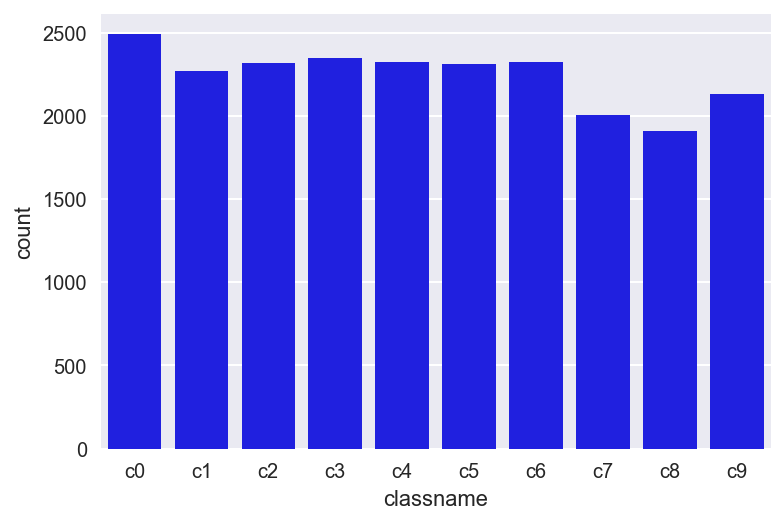

In [59]:
driver_image_list = pd.read_csv(join(pardir, 'data', 'driver_imgs_list.csv'))


sns.set(style="darkgrid")
sns.countplot(x='classname', data=driver_image_list, color='blue')

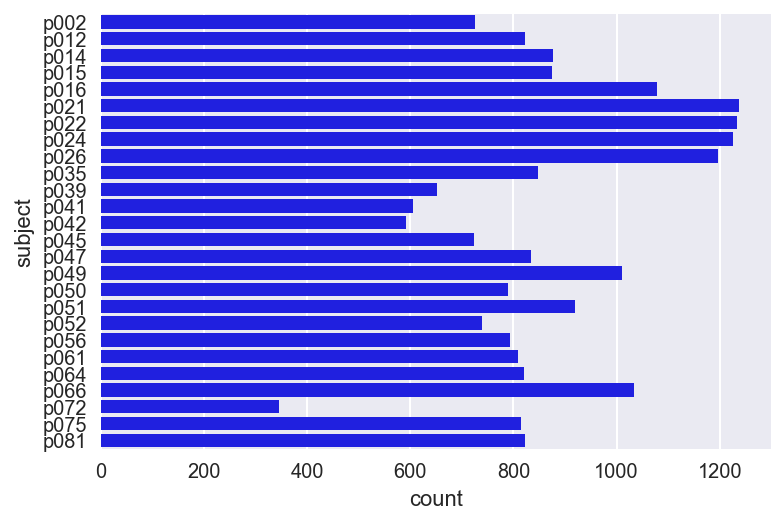

In [60]:
sns.countplot(y='subject', data=driver_image_list, color='blue')

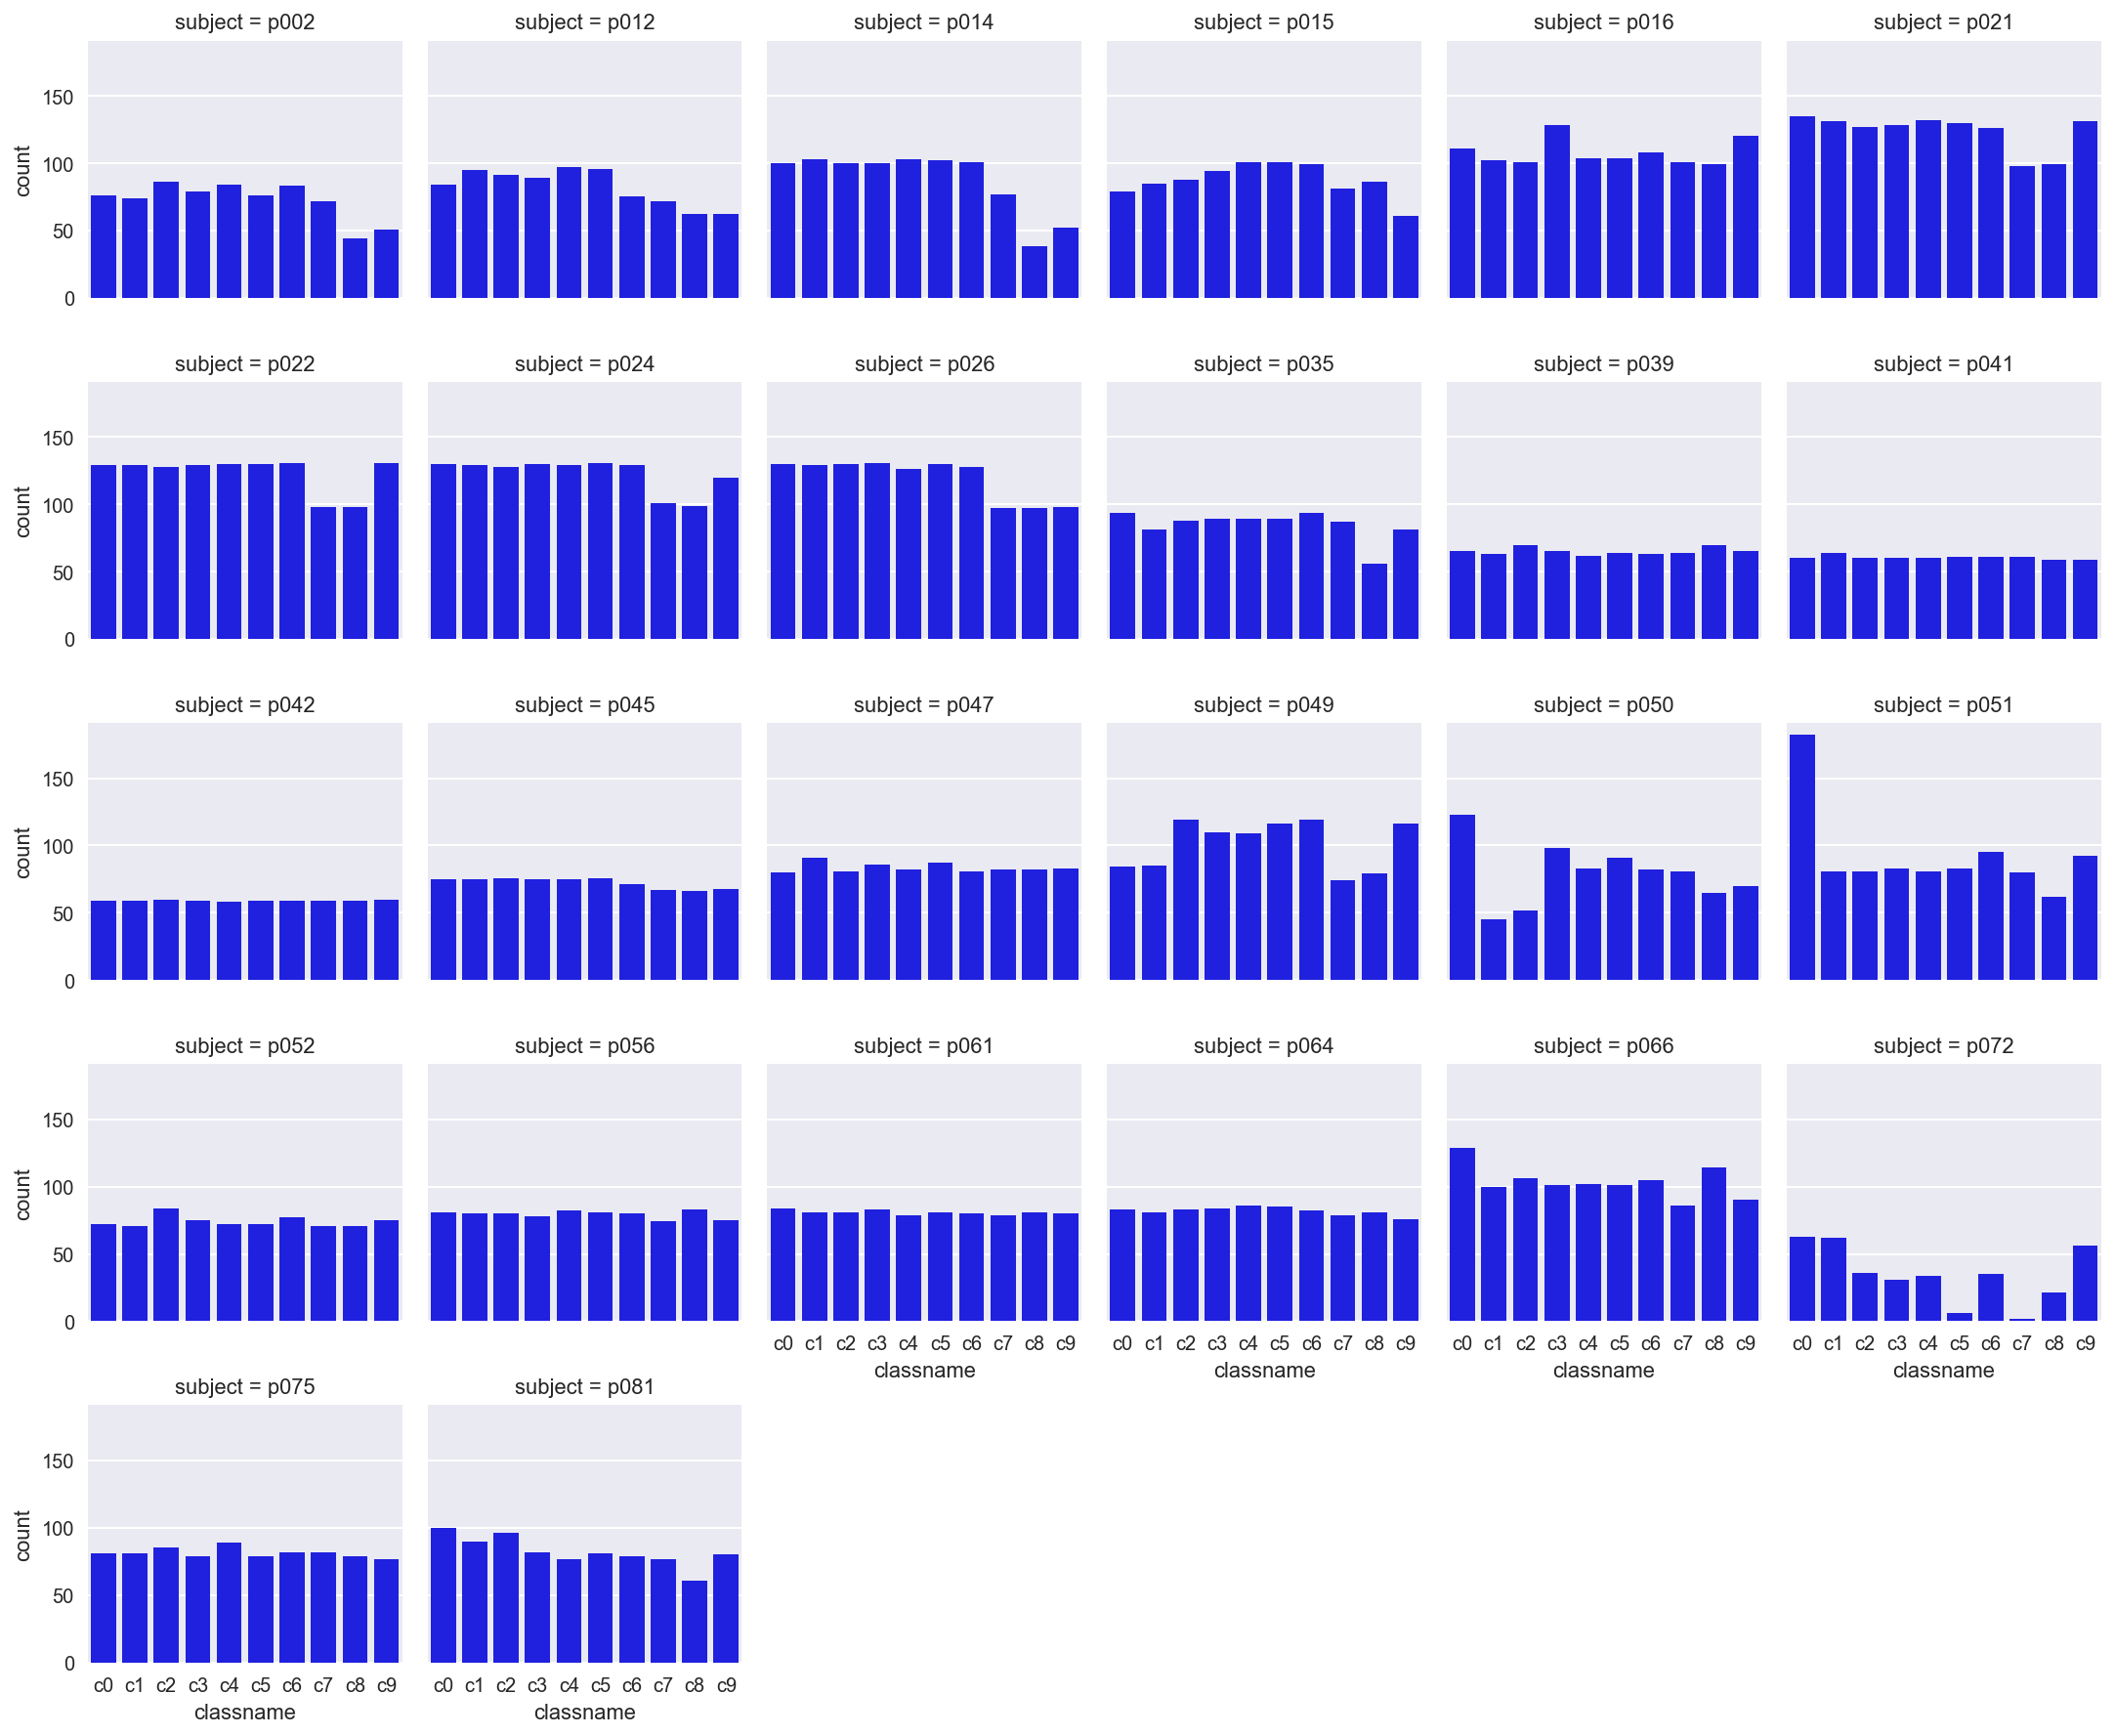

In [61]:
sns.factorplot(x="classname", col='subject', col_wrap=6, data=driver_image_list, kind="count", size=2.5, color='blue')

In [ ]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
zip_path = join(pardir, 'data', 'imgs.zip')

# 解压图像数据压缩包
if not isdir(driver_dataset_folder_path):
    with zipfile.ZipFile(zip_path) as zipfile:
        zipfile.extractall(driver_dataset_folder_path)
        zipfile.close()

(480, 640, 3)


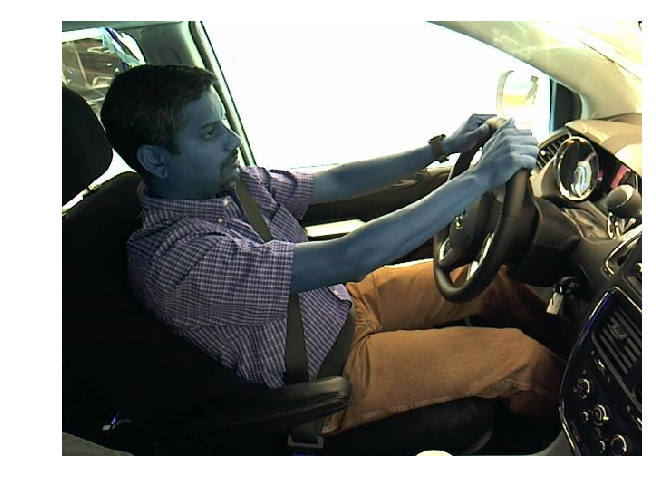

In [53]:
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')

# 示例图片
image_file = join(image_train_folder_path, 'c0', 'img_34.jpg')
image = cv2.imread(image_file)

print(image.shape)

plt.axis('off')
ax = plt.imshow(image)

### 一、加载数据

In [2]:
# vgg16模型图像数据大小固定为224*224
image_size = 224
X = []
y = []
for i in range(10):
    image_path = join(driver_dataset_folder_path, 'train', 'c%s'%i)
    images = glob.glob(join(image_path, '*.jpg'))
    print('loading {}, image count={}'.format(image_path, len(images)))
    for image_file in images:
        image = cv2.imread(image_file)
        X.append(cv2.resize(image, (image_size, image_size)))
        y.append(i)
X = np.array(X)
y = np.array(y)
print('loading complete!')
print(X.shape)
print(y.shape)

loading ../data/driver_dataset/train/c0, image count=2489
loading ../data/driver_dataset/train/c1, image count=2267
loading ../data/driver_dataset/train/c2, image count=2317
loading ../data/driver_dataset/train/c3, image count=2346
loading ../data/driver_dataset/train/c4, image count=2326
loading ../data/driver_dataset/train/c5, image count=2312
loading ../data/driver_dataset/train/c6, image count=2325
loading ../data/driver_dataset/train/c7, image count=2002
loading ../data/driver_dataset/train/c8, image count=1911
loading ../data/driver_dataset/train/c9, image count=2129
loading complete!
(22424, 224, 224, 3)
(22424,)


### 二、创建基准模型

In [32]:
def create_model_vgg16():
    model_vgg16 = VGG16(include_top=False, weights='imagenet')
    
    print('Print vgg16 model summary:')
    print(model_vgg16.summary())

    input = Input(shape=(224, 224, 3), name='image_input')

    output_vgg16_conv = model_vgg16(input)

    x = Flatten()(output_vgg16_conv)

    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### 三、基准模型可视化

Print vgg16 model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 1

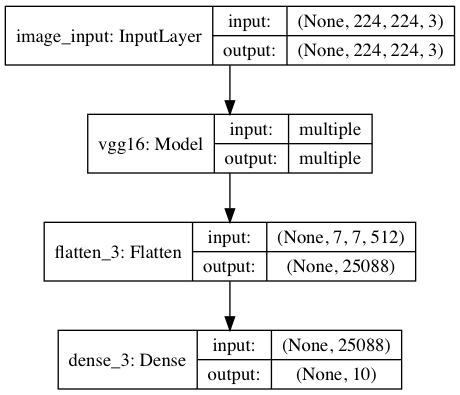

In [10]:
model = create_model_vgg16()
print('Print my model summry:')
print(model.summary())
plot_model(model, show_shapes=True)
Image('model.png')

### 四、划分训练集和验证集

### 五、基准模型预测

In [17]:
out = model.predict(X[5:30:10], verbose=1)
    
print(out)

for pred in out:
    print(np.argmax(pred))

3/3 [==============================] - 2s 723ms/step
[[5.32061586e-15 1.70766748e-10 7.55129076e-05 9.51930881e-01
  1.08887013e-22 3.15284724e-19 1.10814454e-13 2.37301623e-09
  4.79936861e-02 9.78656311e-14]
 [1.76349767e-02 1.08812442e-02 4.68634244e-05 1.04569317e-07
  8.65609527e-01 1.01920702e-01 1.94681358e-17 2.19385372e-03
  1.71277195e-03 1.57569321e-14]
 [4.79705269e-26 9.16661683e-21 6.45430418e-07 4.01415651e-10
  1.67789782e-17 4.37527839e-15 1.45690300e-19 9.99998927e-01
  4.48007427e-07 1.85480570e-18]]
3
4
7


### 六、基准模型评估